In [60]:
import cv2
import numpy as np
from imutils import paths
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Taille des images, nombre de classes, nombre d'époques et taille des lots
IMG_SIZE = (64, 64)
NUM_CLASSES = 6
EPOCHS = 120
BATCH_SIZE = 10

In [61]:
# Chargement des chemins des images du jeu de données
imagePaths = list(paths.list_images("faces_pins_dataset"))

# Initialisation des listes pour les données et les étiquettes
data = []
labels = []

# Parcours des chemins d'images
for imagePath in imagePaths:
    # Extraction de l'étiquette de classe depuis le nom du fichier
    className = imagePath.split("\\")[-2].split("_")[1]
    
    # Lecture de l'image, redimensionnement et normalisation
    image = cv2.imread(imagePath)
    image = cv2.resize(image, IMG_SIZE)
    image = np.array(image) / 255.0

    # Ajout des données de l'image et de l'étiquette aux listes
    data.append(image)
    labels.append(className)

# Conversion des données et des étiquettes en tableaux NumPy
data = np.array(data)
labels = np.array(labels)

# Utilisation de LabelEncoder pour convertir les noms de classes en étiquettes entières
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
# Enregistrement des classes ajustées par LabelEncoder
np.save('./models/label_encoder_classes.npy', label_encoder.classes_)
# Encodage des étiquettes sous forme de vecteurs one-hot
labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2)

In [62]:
# Définition du modèle CNN avec des couches supplémentaires
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation="softmax"))

# Compilation du modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [63]:
# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Planification du taux d'apprentissage
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 50:
        lr *= 0.1
    elif epoch > 25:
        lr *= 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [64]:
# Entraînement du modèle avec augmentation des données et enregistrement de l'historique
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/120
60/60 [==============================] - 15s 115ms/step - loss: 3.5386 - accuracy: 0.2650 - val_loss: 5.3708 - val_accuracy: 0.1325 - lr: 0.0010
Epoch 2/120
60/60 [==============================] - 6s 100ms/step - loss: 2.3678 - accuracy: 0.3250 - val_loss: 8.9807 - val_accuracy: 0.1325 - lr: 0.0010
Epoch 3/120
60/60 [==============================] - 6s 97ms/step - loss: 2.0486 - accuracy: 0.3500 - val_loss: 5.4773 - val_accuracy: 0.1325 - lr: 0.0010
Epoch 4/120
60/60 [==============================] - 6s 97ms/step - loss: 1.6388 - accuracy: 0.4100 - val_loss: 5.4211 - val_accuracy: 0.1325 - lr: 0.0010
Epoch 5/120
60/60 [==============================] - 6s 95ms/step - loss: 1.5014 - accuracy: 0.4250 - val_loss: 4.9027 - val_accuracy: 0.1987 - lr: 0.0010
Epoch 6/120
60/60 [==============================] - 6s 95ms/step - loss: 1.5352 - accuracy: 0.4117 - val_loss: 3.8092 - val_accuracy: 0.2649 - lr: 0.0010
Epoch 7/120
60/60 [==============================] - 6s 96ms/step -

In [65]:
# Sauvegarde du modèle
model.save("./models/celebrity_recognition.h5")

c:\Users\LENOVO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

5/5 [==============================] - 0s 49ms/step - loss: 0.1253 - accuracy: 0.9669
Loss: 0.12531255185604095
Accuracy: 0.9668874144554138


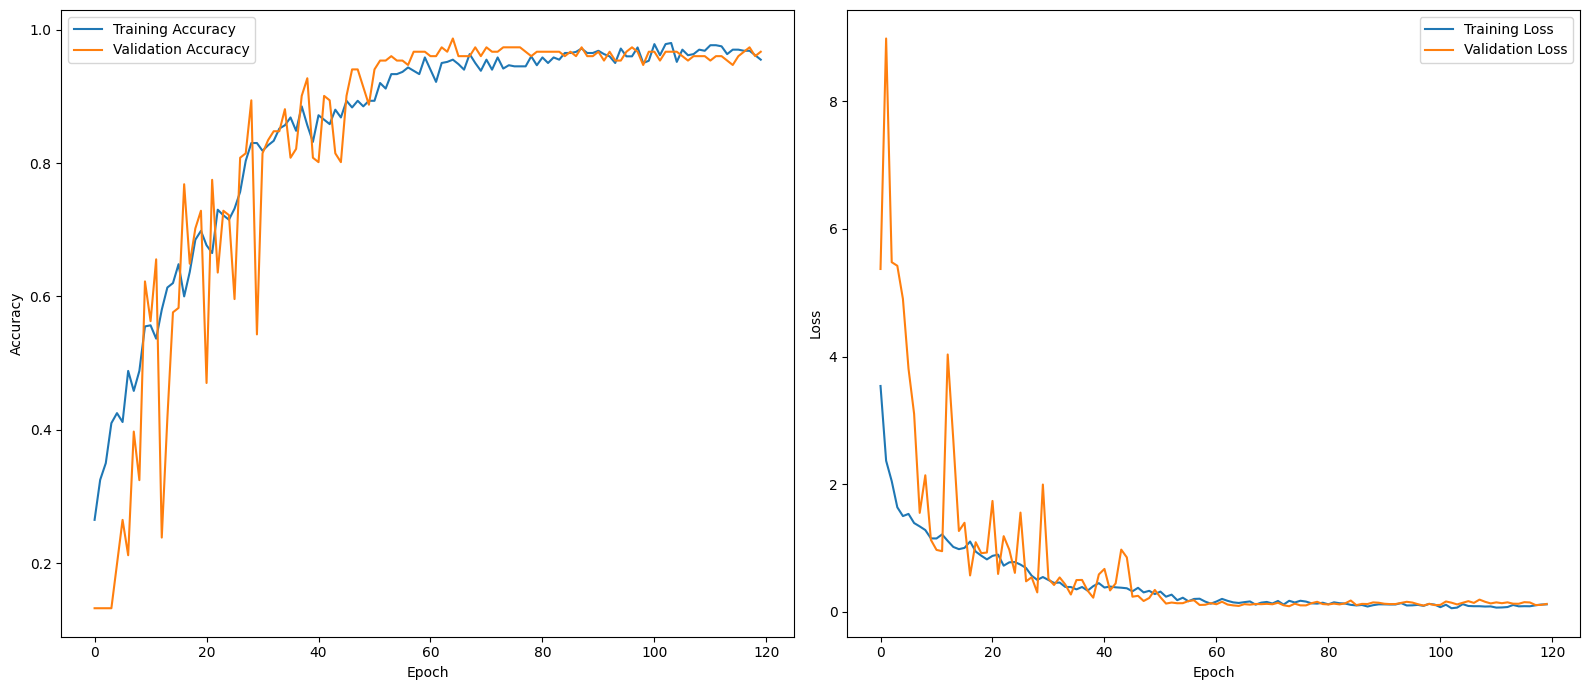

In [67]:
# Tracé de l'historique d'entraînement
plt.figure(figsize=(16, 7))

# Tracé de l'exactitude d'entraînement et de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Tracé de la perte d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 44ms/step


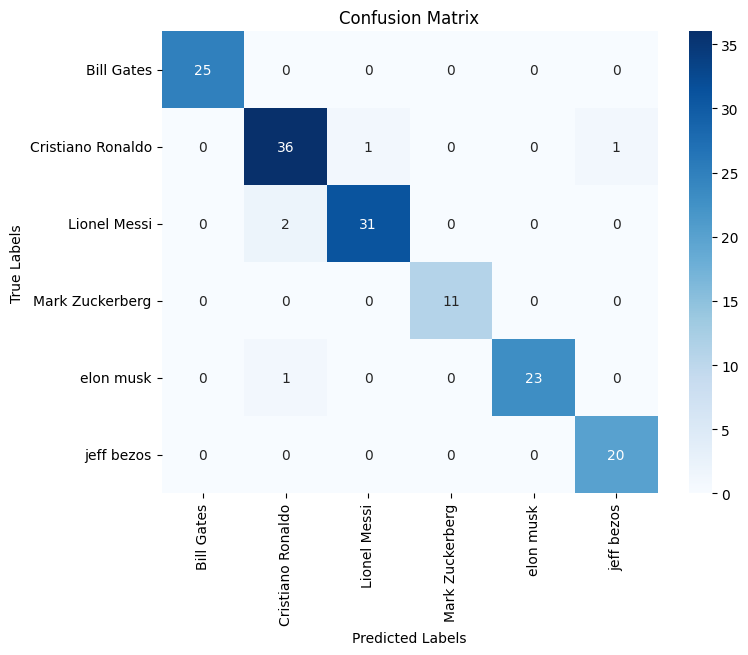

                   precision    recall  f1-score   support

       Bill Gates       1.00      1.00      1.00        25
Cristiano Ronaldo       0.92      0.95      0.94        38
     Lionel Messi       0.97      0.94      0.95        33
  Mark Zuckerberg       1.00      1.00      1.00        11
        elon musk       1.00      0.96      0.98        24
       jeff bezos       0.95      1.00      0.98        20

         accuracy                           0.97       151
        macro avg       0.97      0.97      0.97       151
     weighted avg       0.97      0.97      0.97       151



In [68]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Display the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

In [69]:
# Load the trained model
model2 = load_model("./models/celebrity_recognition.h5")

In [70]:
# Fonction de prédiction d'image
def predict_image(image_path, model, label_encoder):
    # Prétraitement de l'image d'entrée
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))  # Redimensionnement pour correspondre à la forme d'entrée du modèle
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Ajout de la dimension de lot
    
    # Chargement des classes de LabelEncoder
    label_encoder.classes_ = np.load('./models/label_encoder_classes.npy')

    # Prédiction
    predictions = model.predict(img)
    
    # Ajustement et transformation des noms de classe avec LabelEncoder
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = label_encoder.inverse_transform([predicted_class_index])[0]
    predicted_class_accuracy = predictions[0, predicted_class_index]  # Probabilité associée à la classe prédite

    return predicted_class_name, predicted_class_accuracy

1/1 [==============================] - 0s 45ms/step


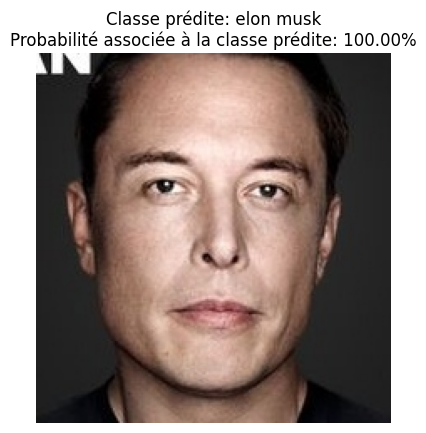

In [74]:
label_encoder = LabelEncoder()

image_path = './faces_pins_dataset/pins_elon musk/elon musk106_1529.jpg'

predicted_name, predicted_accuracy = predict_image(image_path, model2, label_encoder)

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Classe prédite: {predicted_name}\nProbabilité associée à la classe prédite: {predicted_accuracy:.2%}")
plt.axis('off')
plt.show()